In [1]:
USE_GOOGLE_COLAB =True
ROOT_FOLDER_NAME='speech'

if USE_GOOGLE_COLAB:
  #Google drive mount
  from google.colab import drive
  drive.mount('/content/drive')

  %cd 'drive/MyDrive'
%cd $ROOT_FOLDER_NAME

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive
/content/drive/MyDrive/speech


In [2]:
!pwd

/content/drive/MyDrive/speech


In [3]:
!pip install jiwer

In [4]:
from jiwer import wer

In [5]:
reference = 'hello world'
hypothesis = 'hello duck'

error =wer(reference, hypothesis)

print(f'{reference}\n{hypothesis}\nWER : {error}')

hello world
hello duck
WER : 0.5


In [6]:
import jiwer

In [7]:
reference = ['i can spell','i hope']
hypothesis = ['i kan cpell','i hop']

error = jiwer.cer(reference, hypothesis)

print(f'{reference}\n{hypothesis}\nCER: {error}')



['i can spell', 'i hope']
['i kan cpell', 'i hop']
CER: 0.17647058823529413


## CTC 적용 End-to-End 음성인식 모델

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from jiwer import wer


* LibriVox 프로젝트의 LJSpeech 데이터세트 사용하여 모델 생성

  *     7권의 논픽션 책의 구절을 한 사람이 읽는 짧은 오디오클립으로 구성

  *   https://keithito.com/LJ-Speech-Dataset/







In [9]:
# 데이터 준비
data_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
data_path = keras.utils.get_file("LJSpeech-1.1", data_url, untar=True)
wavs_path = data_path + "/wavs/"
metadata_path = data_path + "/metadata.csv"

In [10]:
!pwd

/content/drive/MyDrive/speech


In [11]:
# metadata.csv 데이터프레임 생성
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,normalized_transcription
0,LJ015-0026,"Moreover, the partners were sober, steady men,..."
1,LJ039-0182,Five of the six shots hit the third target whe...
2,LJ018-0278,This was the well and astutely devised plot of...


In [12]:
# 학습 데이터와 검증 데이터 분리
split = int(len(metadata_df)*0.90)
df_train =metadata_df[:split]
df_val = metadata_df[split:]

print(f'Size of the traing set : {len(df_train)}')
print(f'Size of the validation set :{len(df_val)}')


Size of the traing set : 11790
Size of the validation set :1310


## Preprocessing

In [13]:
# 어휘 사전 생성 및 정수 인코딩
character = [x for x in "abcdefghijklmnopqrstuvwxyz'?!"]
char_to_num = keras.layers.StringLookup(vocabulary=character, oov_token="")
num_to_char = keras.layers.StringLookup(
    vocabulary=character, oov_token="",invert=True
)

print(
    f'The Vocabulary is : {char_to_num.get_vocabulary()}'
    f'(size = {char_to_num.vocabulary_size()})'
)


The Vocabulary is : ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!'](size = 30)


In [22]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384


def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    # 5. We only need the magnitude, which can be derived by applying tf.abs
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.math.pow(spectrogram, 0.5)
    # 6. normalisation
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    ###########################################
    ##  Process the label
    ##########################################
    # 7. Convert label to Lower case
    label = tf.strings.lower(label)
    # 8. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 9. Map the characters in label to numbers
    label = char_to_num(label)
    # 10. Return a dict as our model is expecting two inputs
    return spectrogram, label

## DATA Object 생성

In [23]:
batch_size =32

train_dataset =tf.data.Dataset.from_tensor_slices(
    (list(df_train['file_name']), list(df_train['normalized_transcription']))
)
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)#병렬처리
    .padded_batch(batch_size)# 배치사이즈
    .prefetch(buffer_size= tf.data.AUTOTUNE)# 모델이 데이터를 처리하는 동안 백그라운드에 데이터를 미리 읽어 처리속도 향상
)


validation_dataset =tf.data.Dataset.from_tensor_slices(
    (list(df_val['file_name']), list(df_val['normalized_transcription']))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size= tf.data.AUTOTUNE)
)

## Audio 데이터 시각화

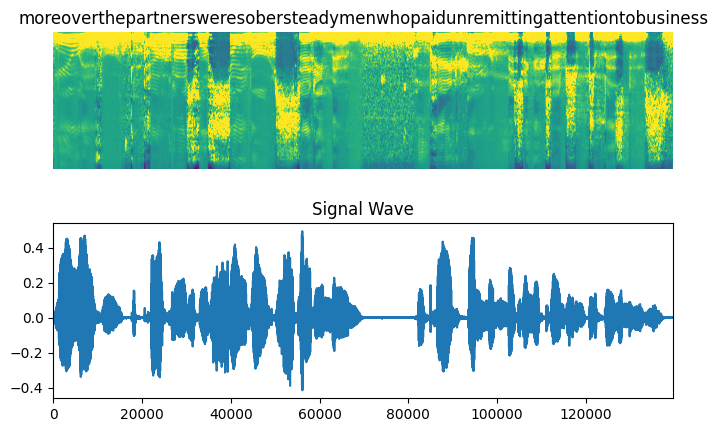

In [24]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrogram = batch[0][0].numpy()
    spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(spectrogram)])
    label = batch[1][0]
    # Spectrogram
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    ax.imshow(spectrogram, vmax=1)
    ax.set_title(label)
    ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, _ = tf.audio.decode_wav(file)
    audio = audio.numpy()
    ax = plt.subplot(2, 1, 2)
    plt.plot(audio)
    ax.set_title("Signal Wave")
    ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()


# CTC LOSS 함수

In [25]:
def CTCLoss(y_true, y_pred):
  batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
  input_length =tf.cast(tf.shape(y_pred)[0],dtype = 'int64')
  label_length =tf.cast(tf.shape(y_true)[1],dtype = 'int64')

  input_length =input_length+ tf.ones(shape = (batch_len,1), dtype ="int64")
  label_length =label_length+ tf.ones(shape = (batch_len,1), dtype ="int64")

  loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

  return loss


In [28]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Model similar to DeepSpeech2."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    # Convolution layer 1
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 41],
        strides=[2, 2],
        padding="same",
        use_bias=False,
        name="conv_1",
    )(x)
    x = layers.BatchNormalization(name="conv_1_bn")(x)
    x = layers.ReLU(name="conv_1_relu")(x)
    # Convolution layer 2
    x = layers.Conv2D(
        filters=32,
        kernel_size=[11, 21],
        strides=[1, 2],
        padding="same",
        use_bias=False,
        name="conv_2",
    )(x)
    x = layers.BatchNormalization(name="conv_2_bn")(x)
    x = layers.ReLU(name="conv_2_relu")(x)
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    # RNN layers
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}",
        )
        x = layers.Bidirectional(
            recurrent, name=f"bidirectional_{i}", merge_mode="concat"
        )(x)
        if i < rnn_layers:
            x = layers.Dropout(rate=0.5)(x)
    # Dense layer
    x = layers.Dense(units=rnn_units * 2, name="ddense_1")(x)
    x = layers.ReLU(name="dense_1_relu")(x)
    x = layers.Dropout(rate=0.5)(x)
    # Classification layer
    output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
    # Model
    model = keras.Model(input_spectrogram, output, name="DeepSpeech_2")
    # Optimizer
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    # Compile the model and return
    model.compile(optimizer=opt, loss=CTCLoss)
    return model

In [29]:
model = build_model(
    input_dim =fft_length // 2+1,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512
)

model.summary()

Model: "DeepSpeech_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None, 193)]       0         
                                                                 
 expand_dim (Reshape)        (None, None, 193, 1)      0         
                                                                 
 conv_1 (Conv2D)             (None, None, 97, 32)      14432     
                                                                 
 conv_1_bn (BatchNormalizati  (None, None, 97, 32)     128       
 on)                                                             
                                                                 
 conv_1_relu (ReLU)          (None, None, 97, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, None, 49, 32)      236544    
                                                      

In [30]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [31]:
# Define the number of epochs.
epochs = 1
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

InvalidArgumentError: ignored

In [ ]:
# Let's check results on more validation samples
predictions = []
targets = []
for batch in validation_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
for i in np.random.randint(0, len(predictions), 5):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print("-" * 100)

In [ ]:
epochs=1

model.fit(

)